# Mobile Price Classification Using SVM

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Reading the dataset
data_set = pd.read_csv('train.csv')
data_set.shape

(2000, 21)

In [6]:
# Checking for null values in the dataset
data_set.isna().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [7]:
# Separating the input features and target variable
X = data_set.iloc[:, :-1]
y = data_set['price_range']

In [8]:
# Splitting the dataset into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape

((1600, 20), (400, 20))

In [9]:
# Scaling the features in the training and test sets
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Finding the Best Parameters Using Halving Grid Search

In [7]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.svm import SVC

In [8]:
# Defining the parameter grid
param_grid = {
    'C': np.logspace(-5, 5, num=50),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto'],                   
}

In [9]:
halving_search = HalvingGridSearchCV(estimator=SVC(random_state=0),
                                     param_grid=param_grid,
                                     cv=5,
                                     factor=3,  
                                     n_jobs=-1,
                                     verbose=3)

halving_search.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 7
n_possible_iterations: 4
min_resources_: 40
max_resources_: 1600
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1600
n_resources: 40
Fitting 5 folds for each of 1600 candidates, totalling 8000 fits
----------
iter: 1
n_candidates: 534
n_resources: 120
Fitting 5 folds for each of 534 candidates, totalling 2670 fits
----------
iter: 2
n_candidates: 178
n_resources: 360
Fitting 5 folds for each of 178 candidates, totalling 890 fits
----------
iter: 3
n_candidates: 60
n_resources: 1080
Fitting 5 folds for each of 60 candidates, totalling 300 fits


HalvingGridSearchCV(estimator=SVC(random_state=0), n_jobs=-1,
                    param_grid={'C': array([1.00000000e-05, 1.59985872e-05, 2.55954792e-05, 4.09491506e-05,
       6.55128557e-05, 1.04811313e-04, 1.67683294e-04, 2.68269580e-04,
       4.29193426e-04, 6.86648845e-04, 1.09854114e-03, 1.75751062e-03,
       2.81176870e-03, 4.49843267e-03, 7.19685673e-03, 1.15139540e-02,
       1.84206997e-02, 2.94705170e-...
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05]),
                                'degree': [2, 3, 4, 5],
                                'gamma': ['scale', 'auto'],
                                'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
                    verbose=3)

In [10]:
# Best parameters found by HalvingGridSearchCV
print('Best score:',halving_search.best_score_)
print('Best parameters found:',halving_search.best_params_)

Best score: 0.962037037037037
Best parameters found: {'C': np.float64(5.1794746792312125), 'degree': 4, 'gamma': 'auto', 'kernel': 'linear'}


### Visualizing the Results

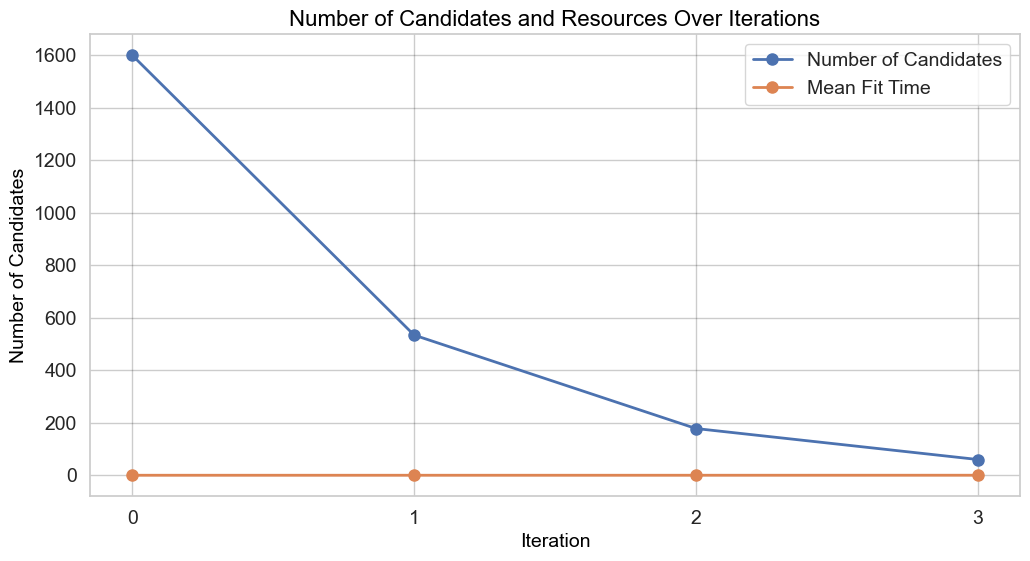

In [11]:
results = pd.DataFrame(halving_search.cv_results_)

iterations = results['iter'].values
n_candidates = results.groupby('iter').size()
mean_fit_time = results.groupby('iter')['mean_fit_time'].mean()

# Visualizing the number of candidates and resources over iterations
plt.figure(figsize=(12, 6))
plt.plot(n_candidates.index, n_candidates.values, marker='o', label='Number of Candidates', linewidth=2, markersize=8) # type: ignore
plt.plot(mean_fit_time.index, mean_fit_time.values, marker='o', label='Mean Fit Time', linewidth=2, markersize=8) # type: ignore
plt.xlabel('Iteration', color='black', fontsize=14)
plt.ylabel('Number of Candidates', color='black', fontsize=14)
plt.title('Number of Candidates and Resources Over Iterations', color='black', fontsize=16)
plt.legend(fontsize=14, ncol=1, loc="upper right")
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(ticks=n_candidates.index)
plt.grid(True, linewidth=1, color='black', alpha=0.2)
plt.show()

In [12]:
# Sorting by score
sorted_indices = np.argsort(results['mean_test_score'])[::-1]
sorted_scores = results['mean_test_score'].values[sorted_indices]
sorted_params = results['params'].values[sorted_indices]

top_params = [str(params) for params in sorted_params[:10]]
top_scores = [str(sc) for sc in sorted_scores[:10]]
param_lb = []
for i in range(1,11):
    param_lb.append('Parameter Combination ' + str(i))

print('Top 10 Parameter Combinations:')
for i in range(len(top_params)):
    print('Parmeter Combination',i+1)
    print(top_params[i])
    print('Score:',top_scores[i])
    print()

Top 10 Parameter Combinations:
Parmeter Combination 1
{'C': np.float64(5.1794746792312125), 'degree': 5, 'gamma': 'auto', 'kernel': 'linear'}
Score: 0.962037037037037

Parmeter Combination 2
{'C': np.float64(5.1794746792312125), 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Score: 0.962037037037037

Parmeter Combination 3
{'C': np.float64(5.1794746792312125), 'degree': 4, 'gamma': 'scale', 'kernel': 'linear'}
Score: 0.962037037037037

Parmeter Combination 4
{'C': np.float64(5.1794746792312125), 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Score: 0.962037037037037

Parmeter Combination 5
{'C': np.float64(5.1794746792312125), 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}
Score: 0.962037037037037

Parmeter Combination 6
{'C': np.float64(5.1794746792312125), 'degree': 5, 'gamma': 'scale', 'kernel': 'linear'}
Score: 0.962037037037037

Parmeter Combination 7
{'C': np.float64(5.1794746792312125), 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
Score: 0.962037037037037

Parmet

## Designing the SVC Model with the Optimal Hyperparameters

In [13]:
best_svc_clf = halving_search.best_estimator_

# Making predictions with the best estimator
y_train_pred = best_svc_clf.predict(X_train) # type: ignore
y_test_pred = best_svc_clf.predict(X_test) # type: ignore

In [14]:
# Computing the performance metrics for the training subset
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

print("Training Accuracy (in %):",round(train_accuracy*100,3))
print("Training Precision (in %):",round(train_precision*100,3)) # type: ignore
print("Training Recall (in %):",round(train_recall*100,3)) # type: ignore
print("Training F1 Score (in %):",round(train_f1*100,3)) # type: ignore

Training Accuracy (in %): 98.25
Training Precision (in %): 98.254
Training Recall (in %): 98.25
Training F1 Score (in %): 98.251


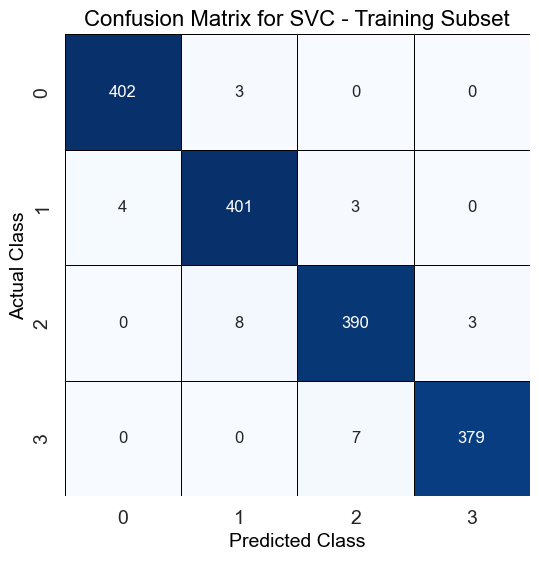

In [15]:
conf_mat_train = confusion_matrix(y_train,y_train_pred)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat_train, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black',
            xticklabels=best_svc_clf.classes_, yticklabels=best_svc_clf.classes_, annot_kws={"size": 12}) # type: ignore
plt.xlabel('Predicted Class', color='black', fontsize=14)
plt.ylabel('Actual Class', color='black', fontsize=14)
plt.title('Confusion Matrix for SVC - Training Subset', color='black', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

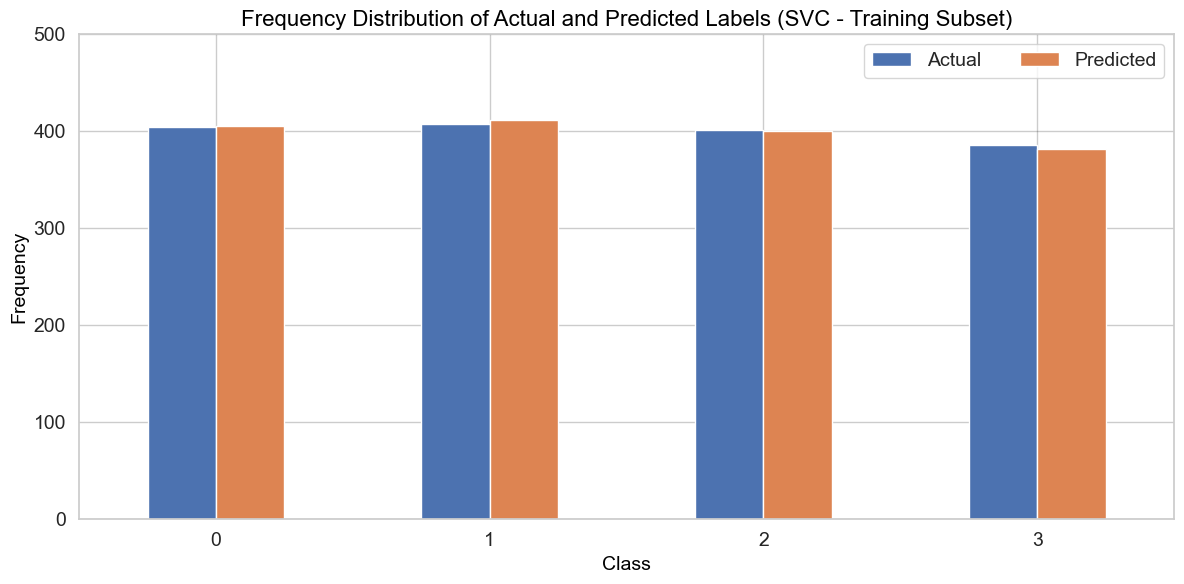

In [16]:
# Plotting the bar graph for frequency distribution of actual and predicted labels (Test Subset)
actual_labels_train, actual_counts_train = np.unique(y_train, return_counts=True)
predicted_labels_train, predicted_counts_train = np.unique(y_train_pred, return_counts=True)

labels_train = np.unique(y_train)

x_train = np.arange(len(labels_train))
width = 0.25

fig, ax = plt.subplots(figsize=(12,6))
rects1_train = ax.bar(x_train - width/2, actual_counts_train, width, label='Actual')
rects2_train = ax.bar(x_train + width/2, predicted_counts_train, width, label='Predicted')

ax.set_xlabel('Class', color='black', fontsize=14)
ax.set_ylabel('Frequency', color='black', fontsize=14)
ax.set_title('Frequency Distribution of Actual and Predicted Labels (SVC - Training Subset)', color='black', fontsize=16)
ax.set_xticks(x_train)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14, ncol=2, loc="upper right")
plt.grid(True, linewidth=1, color='black', alpha=0.2)

ax.set_xlim([-0.5, len(labels_train) - 0.5]) # type: ignore
ax.set_ylim([0,500]) # type: ignore
fig.tight_layout()
plt.show()

In [17]:
# Computing the performance metrics for the test subset
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Test Accuracy (in %):",round(test_accuracy*100,3))
print("Test Precision (in %):",round(test_precision*100,3)) # type: ignore
print("Test Recall (in %):",round(test_recall*100,3)) # type: ignore
print("Test F1 Score (in %):",round(test_f1*100,3)) # type: ignore

Test Accuracy (in %): 94.25
Test Precision (in %): 94.22
Test Recall (in %): 94.25
Test F1 Score (in %): 94.227


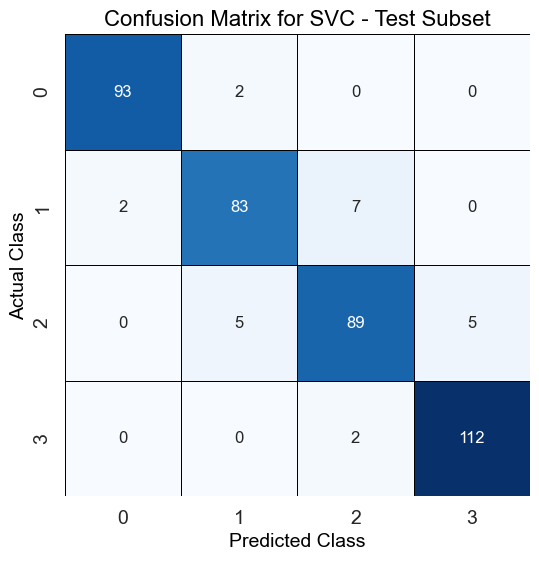

In [18]:
conf_mat_test = confusion_matrix(y_test,y_test_pred)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black',
            xticklabels=best_svc_clf.classes_, yticklabels=best_svc_clf.classes_, annot_kws={"size": 12}) # type: ignore
plt.xlabel('Predicted Class', color='black', fontsize=14)
plt.ylabel('Actual Class', color='black', fontsize=14)
plt.title('Confusion Matrix for SVC - Test Subset', color='black', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

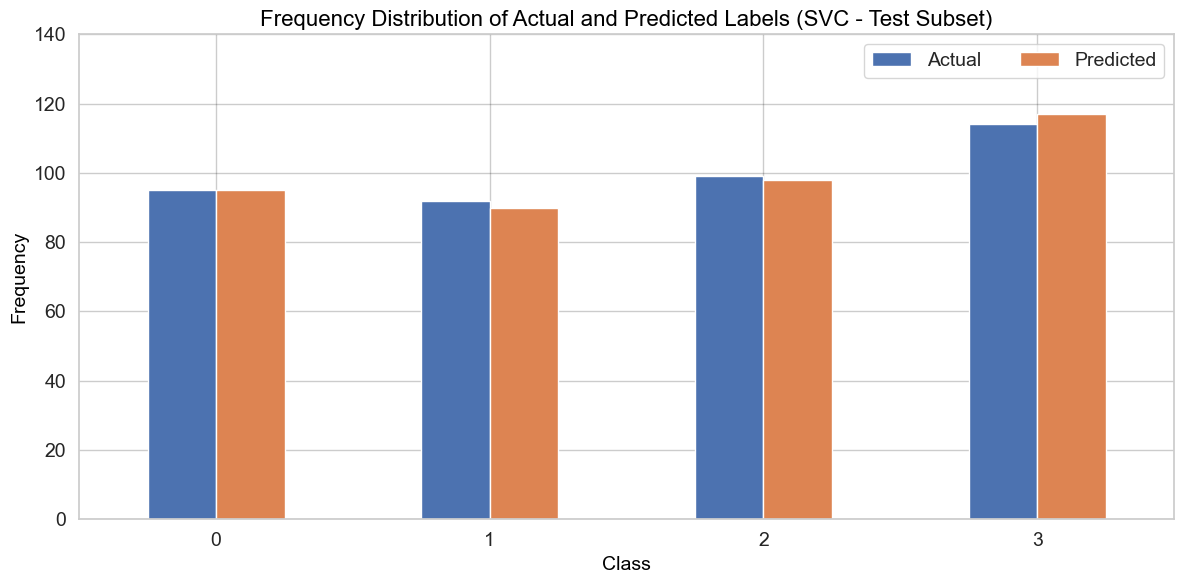

In [19]:
# Plotting the bar graph for frequency distribution of actual and predicted labels (Test Subset)
actual_labels_test, actual_counts_test = np.unique(y_test, return_counts=True)
predicted_labels_test, predicted_counts_test = np.unique(y_test_pred, return_counts=True)

labels_test = np.unique(y_test)

x_test = np.arange(len(labels_test))
width = 0.25

fig, ax = plt.subplots(figsize=(12,6))
rects1_test = ax.bar(x_test - width/2, actual_counts_test, width, label='Actual')
rects2_test = ax.bar(x_test + width/2, predicted_counts_test, width, label='Predicted')

ax.set_xlabel('Class', color='black', fontsize=14)
ax.set_ylabel('Frequency', color='black', fontsize=14)
ax.set_title('Frequency Distribution of Actual and Predicted Labels (SVC - Test Subset)', color='black', fontsize=16)
ax.set_xticks(x_test)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14, ncol=2, loc="upper right")
plt.grid(True, linewidth=1, color='black', alpha=0.2)

ax.set_xlim([-0.5, len(labels_test) - 0.5]) # type: ignore
ax.set_ylim([0,140]) # type: ignore
fig.tight_layout()
plt.show()

***